In [1]:
import numpy as np
import pandas as pd
import glob

import xgboost as xgb

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss, brier_score_loss

import matplotlib.pyplot as plt

In [2]:
parquet_files = glob.glob("data/silver_features/*.parquet")
df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)

print("Total rows:", len(df))
print("Total markets:", df["condition_id"].nunique())

Total rows: 29099
Total markets: 258


In [4]:
df["y_final"] = df["y_final"].astype(int)
df["had_trade"] = df["had_trade"].astype(int)

df["ret_1"] = df["ret_1"].fillna(0.0)
df["vol_7"] = df["vol_7"].fillna(0.0)

df["log_volume"] = np.log1p(df["volume"].astype(float))
df["log_open_interest"] = np.log1p(df["open_interest"].astype(float))
df["log_time_to_close"] = np.log1p(df["time_to_close_sec"].clip(lower=0).astype(float))

In [7]:
DAYS_BEFORE_CLOSE = 7
SECONDS_BEFORE_CLOSE = DAYS_BEFORE_CLOSE * 24 * 60 * 60

df_horizon = df[df["time_to_close_sec"] >= SECONDS_BEFORE_CLOSE].copy()

df_snapshot = (df_horizon.loc[df_horizon.groupby("condition_id")["time_to_close_sec"].idxmin()].copy())

print("Markets after snapshot filtering:", df_snapshot["condition_id"].nunique())
print("Time-to-close (days):")
print((df_snapshot["time_to_close_sec"] / (24*60*60)).describe())

Markets after snapshot filtering: 255
Time-to-close (days):
count    255.000000
mean      25.694907
std       25.658631
min        7.166667
25%        7.208333
50%        7.708333
75%       44.687500
max       87.208333
Name: time_to_close_sec, dtype: float64


In [8]:
feature_cols = [
    "p_mkt",
    "spread",
    "log_volume",
    "log_open_interest",
    "log_time_to_close",
    "ret_1",
    "vol_7",
    "had_trade"
]

X = df_snapshot[feature_cols].astype(float)
y = df_snapshot["y_final"].values
groups = df_snapshot["condition_id"].values

In [9]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train markets:", len(np.unique(groups[train_idx])))
print("Test markets:", len(np.unique(groups[test_idx])))

Train markets: 204
Test markets: 51


In [10]:
p_base = np.clip(X_test["p_mkt"].values, 1e-6, 1-1e-6)

print("Baseline logloss:", log_loss(y_test, p_base))
print("Baseline brier:", brier_score_loss(y_test, p_base))

Baseline logloss: 1.5069526213440239
Baseline brier: 0.2864118306372549


In [11]:
monotone_constraints = (1, 0, 0, 0, -1, 0, 0, 0)

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    monotone_constraints=monotone_constraints,
    random_state=42
)

xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [12]:
p_model = np.clip(xgb_model.predict_proba(X_test)[:, 1], 1e-6, 1-1e-6)

print("XGBoost logloss:", log_loss(y_test, p_model))
print("XGBoost brier:", brier_score_loss(y_test, p_model))

print("\nImprovements vs baseline:")
print("Δ logloss:", log_loss(y_test, p_base) - log_loss(y_test, p_model))
print("Δ brier:", brier_score_loss(y_test, p_base) - brier_score_loss(y_test, p_model))

XGBoost logloss: 0.512428997450917
XGBoost brier: 0.1661422699689865

Improvements vs baseline:
Δ logloss: 0.9945236238931069
Δ brier: 0.12026956066826838


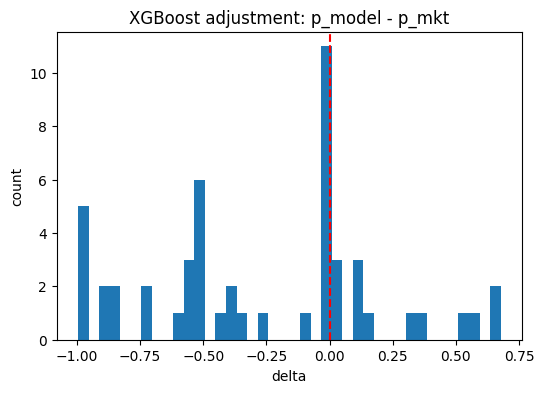

In [13]:
delta = p_model - p_base

plt.figure(figsize=(6,4))
plt.hist(delta, bins=40)
plt.axvline(0, color="red", linestyle="--")
plt.title("XGBoost adjustment: p_model - p_mkt")
plt.xlabel("delta")
plt.ylabel("count")
plt.show()

log_time_to_close    0.340827
p_mkt                0.150097
spread               0.140107
log_open_interest    0.112384
log_volume           0.093371
vol_7                0.088017
ret_1                0.075198
had_trade            0.000000
dtype: float32


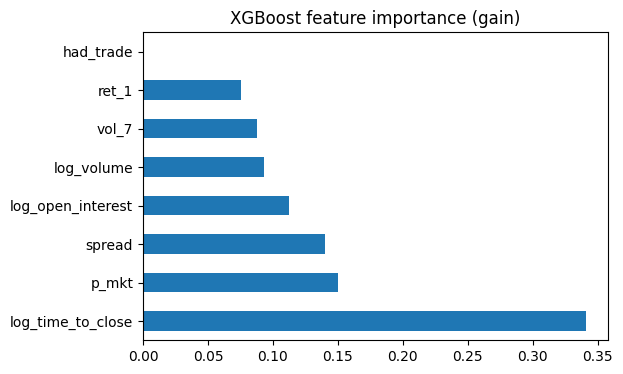

In [16]:
importances = pd.Series(
    xgb_model.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

print(importances)

importances.plot(kind="barh", figsize=(6,4))
plt.title("XGBoost feature importance (gain)")
plt.show()

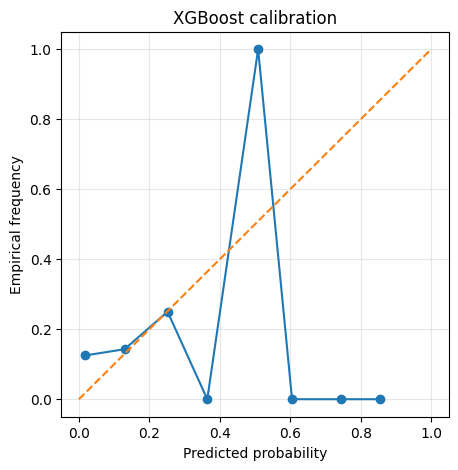

In [17]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, p_model, n_bins=10)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Predicted probability")
plt.ylabel("Empirical frequency")
plt.title("XGBoost calibration")
plt.grid(alpha=0.3)
plt.show()